## Исследование интернет-магазина видеоигр

### Постановка задачи

Заказчик исследования — интернет-магазин, который продаёт по всему миру компьютерные игры.

**Цель исследования** — определить закономерности, определяющие успешность игры, чтобы выявить выявить потенциально популярные продукты и составить план рекламных кампаний.


### План исследования

* Предобработка данных
* Исследовательский анализ данных
* Составление портрета пользователя
* Статистическая проверка гипотез
* Выводы и рекомендации

### Импортирование библиотек

In [1]:
# Импортирование библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings

# Игнорировать все предупреждения
warnings.filterwarnings("ignore")

# Зададим стиль для всех графиков
sns.set_style('darkgrid')

### Загрузка данных

In [2]:
# Прочитаем файл и сохраним его в переменную raw_data
data = pd.read_csv('/Users/aaleksakhin/Library/CloudStorage/GoogleDrive-aaalexahin@gmail.com/My Drive/Data/Datasets/project_games/games.csv')

In [3]:
# Выведение первых строк методом .head()
data.head()

Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08   
2            Mario Kart Wii      Wii           2008.0        Racing     15.68   
3         Wii Sports Resort      Wii           2009.0        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing     11.27   

   EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     28.96      3.77         8.45          76.0          8      E  
1      3.58      6.81         0.77           NaN        NaN    NaN  
2     12.76      3.79         3.29          82.0        8.3      E  
3     10.93      3.28         2.95          80.0          8      E  
4      8.89     10.22         1.00           NaN        NaN    NaN

Датасет состоит из девяти столбцов с данными о выпуске игр.

### Предобработка данных

Выведем основную информацию о датафрейме.

In [4]:
# Вывод основной информации методом .info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В рамках предобработки данных необходимо сделать следующее:

* привести названия всех столбцов к нижнему регистру;
* обработать пропущенные значения;
* проверить датасет на наличие дубликатов;
* при необходимости изменить типы данных.

Начнем с приведения заголовков столбцов к нижнему регистру.

In [5]:
# Приведение названий столбцов к нижнему регистру
data.columns = data.columns.str.lower()

Теперь проверим датасет на наличие пропущенных значений.

In [6]:
# Выведем количество пропущенных значений для каждого столбца
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

* В столбцах `name` и `genre` всего два пропущенных значения, которые могут быть объяснены человеческим фактором и ошибками при сборе данных. Эти строки можно убрать — их удаление существенно не изменит исходный датасет.
* В столбце `year_of_release` пропусков больше — 269. Заменить их нечем, а оперативно восстановить год выпуска каждой игры не представляется возможным. В данном случае строки с пропусками также можно удалить. Итого, количество удаленных строк будет равно 271, это  менее 2% от всего датафрейма, что допустимо.
* В столбцах с оценками критиков и пользователей очень много пропусков — убрать их нельзя, так как удаление пустых строк сильно исказит изначальный датасте. Оставим такие строки без изменений.
* В столбце с возрастным рейтингом также много пропусков. Это может объясняться тем, что ESRB, присваивающая играм рейтинг, является американо-канадской ассоциацией. Вероятно, игры, произведенные в других странах, не попадают под требование оценки со стороны ESRB — у таких игр может быть своя система оценок. Оставим эти пропуски без изменений.

Удалим строки с пропущенными значениями в столбцах `name`, `genre` и `year_of_release`.


In [7]:
# Удалим строки с пропущенными значениями в столбцах `name`, `genre` и `year_of_release`.
data.dropna(subset=['name', 'genre', 'year_of_release'], inplace=True)

В столбце  `user_score`, помимо пустых значений, есть значения `tbd`. `TBD` — это аббревиатура, которая расшифровывается, как `To Be Determined` — такое значение может быть, если игра не набрала достаточного для репрезентативности количества оценок. Не будет ошибкой приравнять значения `tbd` к  `NaN`, так как оба значения имеют одинаковый смысл — оценка неизвестна.

Переведем все значения в столбце `user_score` из типа `object` в тип `float` и заменим `tbd` на `NaN` .

In [8]:
# Заменим тип данных, команда errors='coerce' автоматически заменит 'tbd' на 'NaN'
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')

Дополнительно переведем столбец `year_of_release` из типа `float` в тип  `int`, так как номер года всегда выражается целым числом.

In [9]:
# Заменим типы данных на int
data['year_of_release'] = data['year_of_release'].astype('int')

Проверим датасет на наличие полных дубликатов.

In [10]:
# Проверка дубликатов
data.duplicated().sum()

0

Полные дубликаты отсутствуют, теперь проверим дубликаты по названию игры, платформе и году выпуска. 

In [11]:
data.duplicated(subset=['name', 'platform', 'year_of_release']).sum()

1

Дубликаты в названии игр и платформ могут встречаться, так как игры часто выходят на нескольких платформатах, но дубликаты по всем трем параметрам явно лишние, их нужно удалить.

In [12]:
# Удаление дубликатов
data.drop_duplicates(subset=['name', 'platform', 'year_of_release'], inplace=True)

Проверим результат предобработки

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           9767 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


Все пункты предобработки выполнены — названия столбцов приведены к нижнему регистру, типы данных изменены, пропуски обработаны. Проверим, насколько сильно уменьшился полученный датафрейм по сравнению с исходным — разделим длину текущего датафрейму на длину исходного датафрейма.

In [14]:
(1 - (len(data)/16715))*100

1.6272808854322474

Датафрейм уменьшился на `1.6%` — это в рамках допустимого предела в `5%`.

Для последующего анализа данных посчитаем суммарные продажи по всем регионам и добавим полученные значения в новый столбец.

In [15]:
# Добавление нового столбца
data['total_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

### Исследовательский анализ данных

Проведем исследовательский анализ данных. Для начала посмотрим на количество выпущенных игр по годам — построим столбчатую диаграмму.

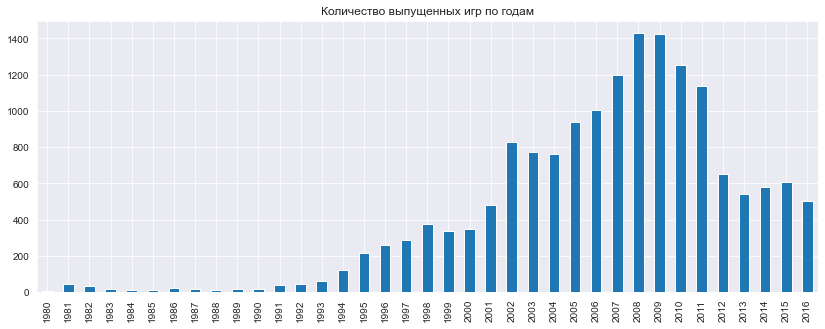

In [16]:
# Зададим размер графика
plt.figure(figsize=(14,5))

# Построение диаграммы
data.groupby('year_of_release')['name'].count().plot(kind='bar')
plt.title('Количество выпущенных игр по годам')
plt.xlabel('')

# Выведение графика
plt.show()

Больше всего игр было выпущено в 2008 и 2009 годах — более 1,4 тысячи. Заметный рост индустрии видеоигр начался с начала 1990-х годов. Количество игр в 2016 году меньше, чем годом ранее, так как данные за 2016 год не полные. 

Посмотрим динамику продаж по наиболее популярным платформам за всем время — выберем топ-10 платформ с наибольшим количеством продаж.

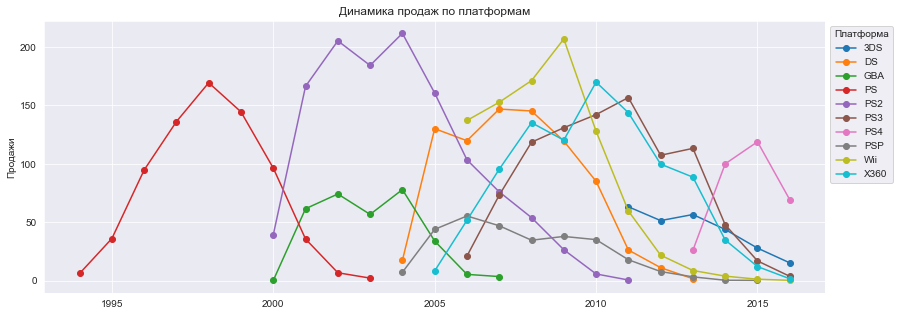

In [17]:
# Заздадим количество анализируемых платформ
number_of_platforms = 10

# Сгруппируем таблицу по платформам и сократим полученный датасет до количества платфорт 
# в предыдущей переменной
top_platforms_by_sales = (data.groupby('platform')['total_sales']
                                .sum()
                                .reset_index()
                                .sort_values(by='total_sales', ascending = False)
                                .head(number_of_platforms))

# Построим сводную таблицу продаж по годам для топ-10 платформ
pivot_sales = (data.loc[(data['platform'].isin(top_platforms_by_sales['platform']))
                        & (data['year_of_release'] >= 1994)]    \
                  .pivot_table(index='year_of_release',
                               columns = 'platform', aggfunc='sum', values='total_sales'))

# Построение графика
pivot_sales.plot(kind='line', marker='o', linestyle='-', grid=True, figsize=(14,5))
plt.xlabel('')
plt.ylabel('Продажи')
plt.title('Динамика продаж по платформам')
plt.legend(title='Платформа', bbox_to_anchor=(1, 1)) 
plt.show()

Характерно, что срок жизни платформы в среднем составляет от 7 до 10 лет.

Зададим временные границы дальнейшего анализа — возьмем наиболее акутальные данные за период с 2013 по 2016 годы.

In [18]:
# Зададим границы анализируемого периода
actual_period_min = 2013
actual_period_max = 2016

# Сохраним данные за анализируемый период в отдельную переменную
actual_data = (data.loc[(data['year_of_release'] >= actual_period_min) &
                        (data['year_of_release'] <= actual_period_max)])

Построим график динамики продаж по платформам для актуального периода и определим потенциально наиболее прибыльные платформы 

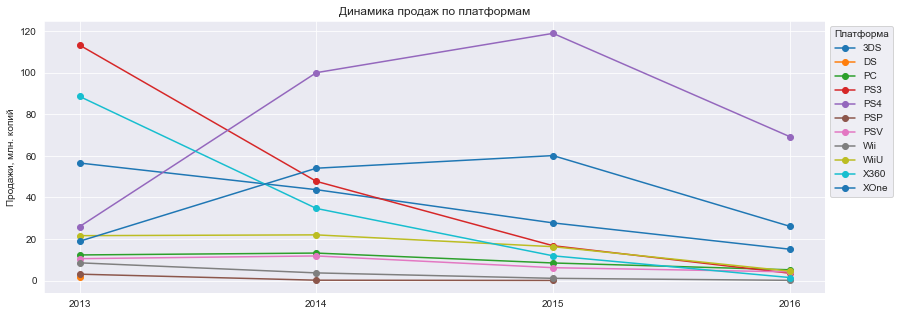

In [19]:
# Создадим сводную таблицу по годам
pivot_actual_data = actual_data.pivot_table(index='year_of_release',
                                            columns = 'platform',
                                            aggfunc='sum',
                                            values='total_sales')
                    
# Сохраним индексы сводной таблицы в формате int для корректного отображения графика
pivot_actual_data.index = pivot_actual_data.index.astype(int)

# Созжание графика
ax = pivot_actual_data.plot(kind='line', marker='o', linestyle='-', grid=True, figsize=(14,5))
plt.xlabel('')
plt.ylabel('Продажи, млн. копий')
plt.title('Динамика продаж по платформам')
plt.legend(title='Платформа', bbox_to_anchor=(1, 1))
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.show()


C 2014 по 2015 годы рост продаж наблюдается у двух платформ — PS4 и XOne, эти плаформы можно считать наиболее перспективными. По графику в 2016 году на всех платформах наблюдается снижение, которое связано с неполнотой данных. Данные были предоставлены в декабре 2016 года — в них точно не были учтены продажи во время новогодних и рождественских праздников, которые потенциально занимают большую долю от годовых продаж.

Посмотроим на распределние продаж в каждой платформе — построим боксплоты.

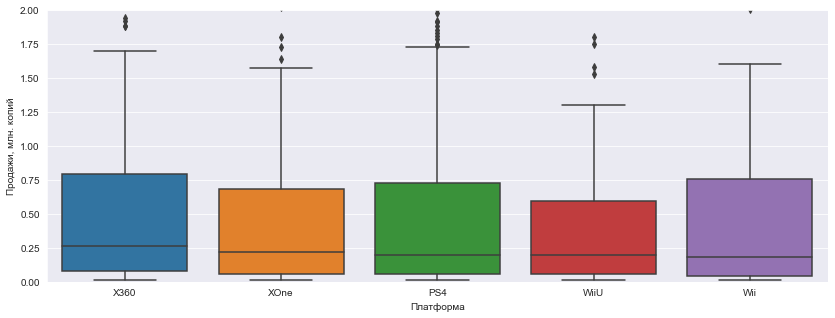

In [20]:
# Группировка данных по платформам, расчет медианного значения продаж для каждой платформы
median_sales_by_platform = (actual_data.groupby('platform')['total_sales']
                                       .median()
                                       .sort_values(ascending=False)
                                       .head())

# Получим название платформ в порядке убывания медианных продаж 
sorted_platforms = median_sales_by_platform.sort_values(ascending=False).index

# Построение графика
plt.figure(figsize=(14, 5))
plt.ylim(0,2)
sns.boxplot(x='platform', y='total_sales', data=actual_data, order=sorted_platforms)
plt.xlabel('Платформа')  
plt.ylabel('Продажи, млн. копий') 
plt.show()

Наибольшее медианное количество проданных копий было выпущено на платформах X360, XOne, PS4, WiiU и Wii — около 0.25 млн копий.

Посмотрим, как внутри одной платформы отзывы критиков и пользователей влияют на продажи. Постройте диаграмму рассеяния для PS4 и XOne и посчитаем корреляцию между отзывами и продажами.


('Платформа PS4: корреляция между продажами и показателем user_score:',
 -0.03195711020455645)

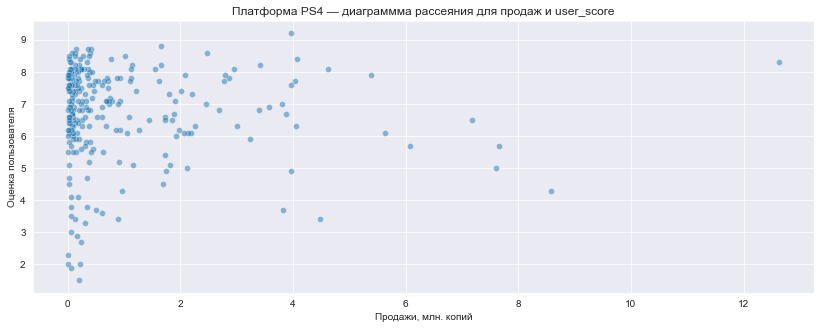

('Платформа PS4: корреляция между продажами и показателем critic_score:',
 0.40656790206178145)

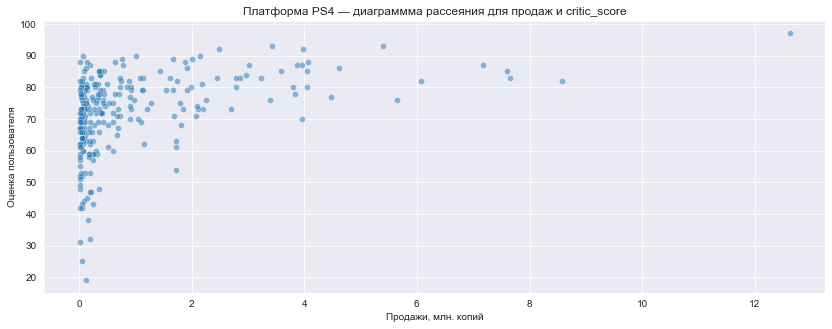

('Платформа XOne: корреляция между продажами и показателем user_score:',
 -0.0689250532827942)

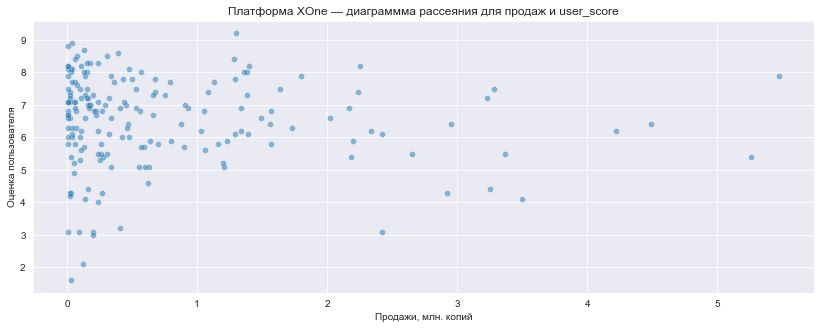

('Платформа XOne: корреляция между продажами и показателем critic_score:',
 0.4169983280084016)

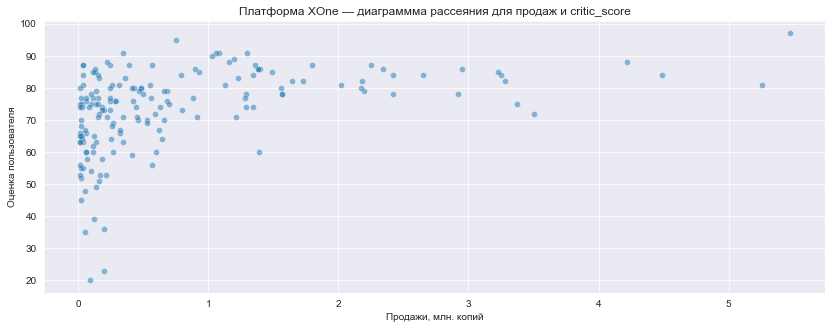

In [21]:
# Зададим списки для цикла
scores = ['user_score', 'critic_score']
platforms = ['PS4', 'XOne']

# Зададим цикл
for p in platforms:
    platform_actual_data = actual_data.loc[actual_data['platform'] == p]
    for s in scores:
        # Выведем корреляцию
        display ((f'Платформа {p}: корреляция между продажами и показателем {s}:'
                  ,platform_actual_data['total_sales'].corr(platform_actual_data[s])))
        # Построение графика
        plt.figure(figsize=(14, 5))
        sns.scatterplot(x=platform_actual_data['total_sales'],
                        y=platform_actual_data[s],
                        data=platform_actual_data,
                        alpha=0.5)
        plt.title(f'Платформа {p} — диаграммма рассеяния для продаж и {s}')
        plt.xlabel('Продажи, млн. копий')
        plt.ylabel('Оценка пользователя')
        plt.grid(True)
        plt.show()

Корреляция между оценкой пользователя и количеством проданных копий очень низкая — можно сказать, что оценка пользователей не влияет на продажи видеоигр. Корреляция между оценкой критиков и продажами уже больше — в районе 0,4 — мнение критиков на продажи влияют больше. По всей видимости, большая часть пользователей покупают игры в рамках предзаказа, не дожидаясь появление пользовательских оценок.

Посмотрим на общее распределение игр по жанрам и изучим самые прибыльные из них по показателю медианных продаж.


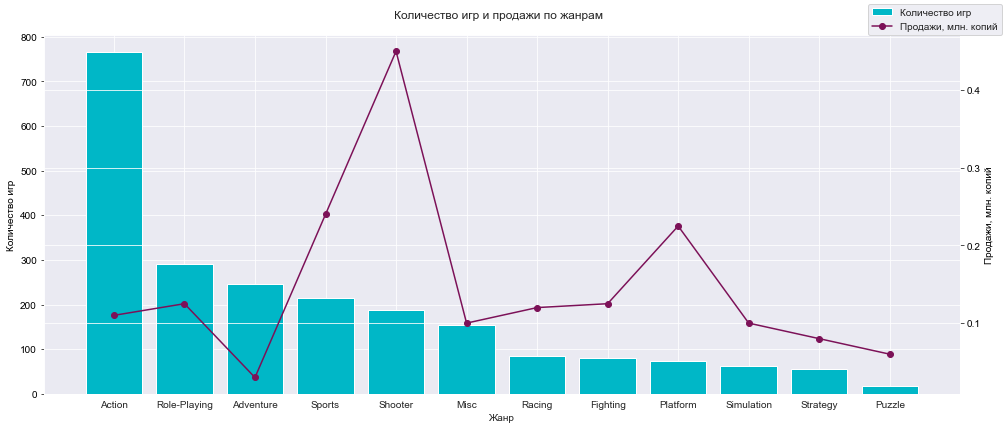

In [22]:
# Построим сводную таблицу по жанрам
# в значениях укажем два столбца — с количеством игр и медианой проданных копий
pivot_act_data = actual_data.pivot_table(index='genre',
                                         values='total_sales',
                                         aggfunc=['count', 'median'])

pivot_act_data.columns = ['games_count', 'total_sales']
pivot_act_data = pivot_act_data.reset_index().sort_values(by='games_count', ascending=False)

fig, ax1 = plt.subplots(figsize=(14, 6))

# Для количества игр построим столбчатую диаграмму
ax1.bar(pivot_act_data['genre'],
        pivot_act_data['games_count'],
        color='#00b7c7',
        label='Количество игр')

ax1.set_xlabel('Жанр')
ax1.set_ylabel('Количество игр', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Создадим вторую ось для количества проданных копий
ax2 = ax1.twinx()

# Построим линейный график для продаж
ax2.plot(pivot_act_data['genre'],
         pivot_act_data['total_sales'],
         marker='o',
         color='#7c1158',
         label='Продажи, млн. копий')

ax2.set_ylabel('Продажи, млн. копий', color='black')
ax2.tick_params(axis='y', labelcolor='black')

fig.suptitle('Количество игр и продажи по жанрам ')
fig.tight_layout()
fig.legend(loc='upper right')

plt.xticks(rotation=45)
plt.grid(True)
plt.show()


Наиболее распространенные жанры среди игр: Action, Role-Playing, Adventure и Sports, самые непопулярные игры — в жанре Puzzle и Strategy. По продажам распределение выглядит  иначе, самый продаваемый (с большим отрывом от остальных) жанр — Shooter, на втором месте жанр Platform.

### Составление портрета пользователя

Изучим топ-5 платформ и жанров по количеству проданных копий отдельно для каждого региона, напишем для этого функцию.

In [23]:
# В функции будет три переменные:датасет, названия категории (платформа или жанр)
# и количество категорий для анализа (по умолчанию 5)
def regions_top_by_categories(df, category, num_of_categories=5):
    
    # Сделаем списки для цикла
    region_sales = ['na_sales', 'eu_sales', 'jp_sales']
    region_names = ['Северной Америке', 'Европе', 'Японии']
    
    # Создание сводной таблицы по категории
    category_pivot = df.pivot_table(index=category,
                                    aggfunc='sum',
                                    values=region_sales).reset_index()

    # Объявление цикла
    for s, n in zip(region_sales, region_names):
        # Расчет доли продаж для определенного региона
        category_pivot['region_share'] = category_pivot[s] / sum(category_pivot[s])
        # Создание топа категорий по продажам
        top = (category_pivot[[category, 'region_share']]
               .sort_values(by='region_share',ascending=False).head(num_of_categories))
        # Сохранение топовых категорий в отдельную переменную
        top_categories = top[category].values
        # Отнесем все категории, не попавшие в топ, в категорию "Другое" — 
        # создадим для этого столбец 'category_group'
        category_pivot['category_group'] = (category_pivot[category].apply
                                            (lambda x: x if x in top_categories else 'Другое'))
        # Группировка по новому столбцу
        top_grouped = category_pivot.groupby('category_group')['region_share'].sum().reset_index()
        
        # Построение круговой диаграммы
        plt.figure(figsize=(7, 7))
        plt.title(f'Топ-{num_of_categories} категорий "{category}" по продажам в {n}')
        plt.pie(top_grouped['region_share'],
                labels=top_grouped['category_group'],
                autopct='%1.1f%%',
                startangle=140)
        
        plt.show()
        
        # Выведение таблицы
        display(category_pivot[[category, s]].sort_values(by=s, ascending=False).head())

Проверим, как работает функция — посмотрим на топ-5 платформ по количеству проданных копий в каждом регионе.

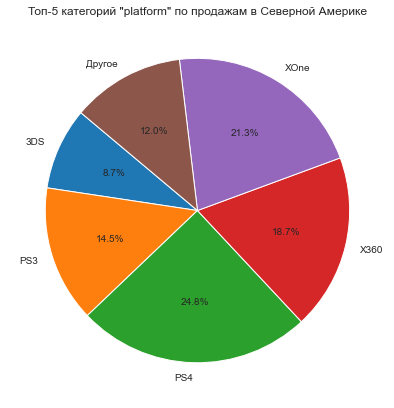

platform  na_sales
4       PS4    108.74
10     XOne     93.12
9      X360     81.66
3       PS3     63.50
0       3DS     38.20

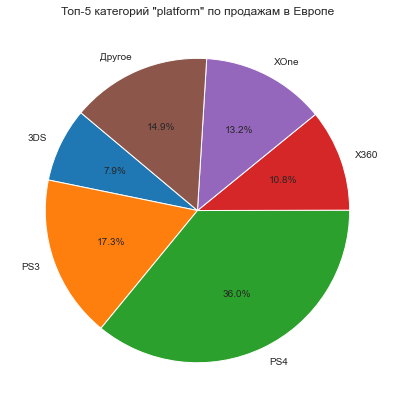

platform  eu_sales
4       PS4    141.09
3       PS3     67.81
10     XOne     51.59
9      X360     42.52
0       3DS     30.96

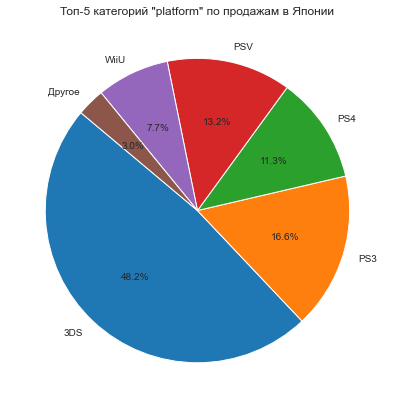

platform  jp_sales
0      3DS     67.81
3      PS3     23.35
6      PSV     18.59
4      PS4     15.96
8     WiiU     10.88

In [24]:
# Вызов функции
regions_top_by_categories(actual_data, 'platform')

В Японии распределение платформ по продаж существенно отличается от Северной Америки и Европы. В Японии игры на платформе 3DS самые продаваемые — почти в 3 раза больше, чем в PS3, которая в Японии занимает второе место по продажа. В Северной Америке и Европе 3DS занимает последнее место — там наиболее продаваемой платформой является PS4.

Теперь рассмотрим такую же статистику в разбивке по жанрам.

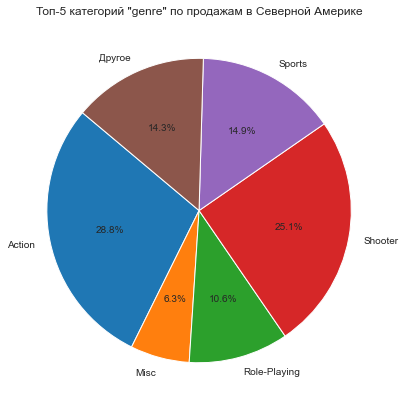

genre  na_sales
0         Action    126.05
8        Shooter    109.74
10        Sports     65.27
7   Role-Playing     46.40
3           Misc     27.49

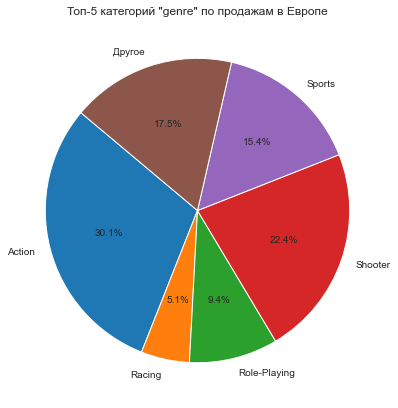

genre  eu_sales
0         Action    118.13
8        Shooter     87.86
10        Sports     60.52
7   Role-Playing     36.97
6         Racing     20.19

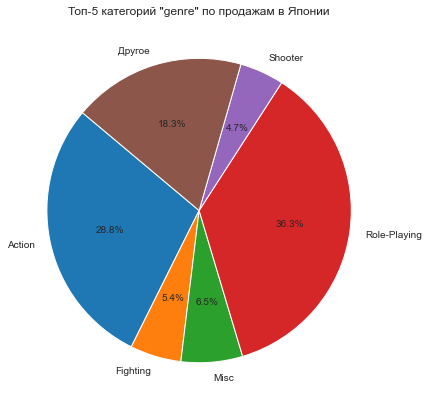

genre  jp_sales
7  Role-Playing     51.04
0        Action     40.49
3          Misc      9.20
2      Fighting      7.65
8       Shooter      6.61

In [25]:
# Вызов функции
regions_top_by_categories(actual_data, 'genre')

В Европе и Северной Америке среди жанров по продажам лидируют Action, в Японии этот жанр занимает второе место, уступая первое место ролевых играм. Топ-5 у Северной Америке и Европы почти одинаковые, отличаются только последние места — в Северной Америке это ролевые игры, в Европе — гонки. Интересно, что популярный в западных странах жанр Shooter, в Японии занимает последнее пятое место.

Теперь исследуем, как возратной рейтинг влияет на продажи в каждом регионе — рассмотрим средее количество проданных копий для каждого возрастного рейтинга. Предвариетельно исключим из региона те игры, продажи которых равны нулю — скорее всего такие игры не продавались в регионе. Если оставить нулевыые значения, они могут искуственно занизить результат.

In [26]:
# Создание списков для цикла
region_sales = ['na_sales', 'eu_sales', 'jp_sales']
region_names = ['Северной Америке', 'Европе', 'Японии']

# Для каждого региона исключим строки с нулевыми продажами,
# сгруппируем строки по рейтингу и посчитвем средний продажи
for s, n in zip (region_sales, region_names):
    display (f'Среднее количество проданных копий по возрастным рейтингам в {n}')
    display ((actual_data.loc[actual_data[s] > 0]
                         .groupby('rating')[s]
                         .mean()
                         .reset_index()
                         .sort_values(by=s, ascending=False)))
                                                                                                       
                                                                                                       
                                                                                                      

'Среднее количество проданных копий по возрастным рейтингам в Северной Америке'

rating  na_sales
2      M  0.494641
0      E  0.364286
1   E10+  0.246545
3      T  0.207458

'Среднее количество проданных копий по возрастным рейтингам в Европе'

rating  eu_sales
2      M  0.431217
0      E  0.314566
1   E10+  0.184805
3      T  0.165810

'Среднее количество проданных копий по возрастным рейтингам в Японии'

rating  jp_sales
0      E  0.196623
3      T  0.113757
1   E10+  0.101552
2      M  0.088742

Рейтинг влияет на продажи в разных регионах по-разному. В Северной Америке и Европе распределение мест одинаковое. Игры с рейтингом M продаются лучше всего. В Японии наиболее популярны игры с рейтингом E (для всех возрастов). Есть предположение, что в Японии чаще всего играют дети — это может объяснить популярность рейтингов "для всех" и непопулярность шутеров.

### Статистическая проверка гипотез

Проверим, отличаются ли средние пользователиские оценки для жанров Action и Sports. Для проверки гипотез будем использовать стандартный t-тест. Сформулируем гипотезы:

* H0: средние пользовательские оценки для жанров Action и Sports не отличаются 
* H1: средние пользовательские оценки для жанров Action и Sports отличаются 

In [27]:
# Создадим объекты Series с пользовательскими оценами для жанров
action = data.loc[(actual_data['genre'] == 'Action')&(data['user_score'] > 0)]['user_score']
sports = data.loc[(actual_data['genre'] == 'Sports')&(data['user_score'] > 0)]['user_score']

# Проведем t-test, результаты запишем в перемменную results
results = st.ttest_ind(action, sports, equal_var=False) 

# Зададим уровень статистической значимости = 0.05
alpha = .05 

print('p-значение:', results.pvalue)

# Сравним p-value с alpha
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 


p-значение: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута — средние пользовательские оценки для жанров Action и Sports статистически значимо отличаются.

Теперь проверим, различаются ли средние оценки для платформ XOne и PC. Сформулируем гипотезы:

* H0: средние пользовательские оценки для платфорт XOne и PC не отличаются 
* H0: средние пользовательские оценки для платфорт XOne и PC отличаются 


In [28]:
# Создадим объекты Series с пользовательскими оценами для жанров
xone = data.loc[(actual_data['platform'] == 'XOne')&(data['user_score'] > 0)]['user_score']
pc = data.loc[(actual_data['platform'] == 'PC')&(data['user_score'] > 0)]['user_score']

# Проведем t-test, результаты запишем в перемменную results
results = st.ttest_ind(xone, pc, equal_var=False) 

# Зададим уровень статистической значимости = 0.05
alpha = .05 

print('p-значение:', results.pvalue)

# Сравним p-value с alpha
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 


p-значение: 0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


Не получилось отвергнуть нулевую гипотезу — средние пользовательские оценки для платформ XOne и PC статистически значимо не отличаются.

### Выводы

В ходе анализа были выполнены следующие работы:

* Предобработка данных: обработка пропущенных значений, проверка на наличие дубликатов, изменение типов данных.
* Исследовательский анализ данных: анализ динамики выпускаемых игр и продаж по годам, анализ корреляции между оценками и продажами, анализ наиболее популярных жанрорв по продажам и количеству выпускаемых игр.
* Составление портера пользователя в каждом регионе — анализ наиболее популярных жанров и платформ, анализ рейтингов
* Статистическая проверка гипотез

**Основные выводы**:

* Больше всего игр было выпущено в 2008 и 2009 годах — более 1,4 тысячи. Заметный рост индустрии видеоигр начался с начала 1990-х годов.
* Срок жизни платформы в среднем составляет от 7 до 10 лет.
* Только у PS4 и XOne наблюдается рост продаж на 2015 год. Эти платформы являются наиболее перспективными.
* Корреляция между оценкой пользователя и количеством проданных копий очень низкая — можно сказать, что оценка пользователей не влияет на продажи видеоигр. Корреляция между оценкой критиков и продажами уже больше —  мнение критиков на продажи влияют больше. По всей видимости, большая часть пользователей покупают игры в рамках предзаказа, не дожидаясь появление оценок.
* Наиболее распространенные жанры среди игр: Action, Role-Playing, Adventure и Sports. Самый продаваемый (с большим отрывом от остальных) жанр — Shooter, на втором месте жанр Platform.
* В Японии распределение платформ по продаж существенно отличается от Северной Америки и Европы. В Японии игры на платформе 3DS самые продаваемые — почти в 3 раза больше, чем в PS3, которая в Японии занимает второе место по продажа. В Северной Америке и Европе 3DS занимает последнее место — там наиболее продаваемой платформой является PS4.
* В Европе и Северной Америке среди жанров по продажам лидируют Action, в Японии этот жанр занимает второе место, уступая первое место ролевых играм. Топ-5 у Северной Америке и Европы почти одинаковые, отличаются только последние места — в Северной Америке это ролевые игры, в Европе — гонки. Интересно, что популярный в западных странах жанр Shooter, в Японии занимает последнее пятое место.
* Рейтинг влияет на продажи в разных регионах по-разному. В Северной Америке и Европе распределение мест почти одинаковое, а топ-3 полностью одинаковый. Игры с рейтингом АО (игры 18+) продаются лучше всего. В Японии наиболее популярны игры с рейтингом E (для всех возрастов). Есть предположение, что в Японии чаще всего играют дети — это может объяснить популярность рейтингов "для всех" и непопулярность шутеров.

